### 1. Setup

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import scipy.stats as stats

from utils import data_prep as dp, feature_gen as fg, feature_select as fs, backtest as bt

### 2. Load & Clean Data

In [2]:
exchange = "binance"

start_date = "20230101"
end_date = "20241231"

start_dt = dt.datetime.strptime(start_date, "%Y%m%d")
end_dt = dt.datetime.strptime(end_date, "%Y%m%d")

In [3]:
DATA_PATH = "/data/time_series/market_data/"

level1_data = dp.get_files(start_dt, end_dt, "level1", exchange, "futures", "BTCUSDT",DATA_PATH)
book_data = dp.get_files(start_dt, end_dt, "book", exchange, "futures", "BTCUSDT",DATA_PATH)
trade_data = dp.get_files(start_dt, end_dt, "trade", exchange, "futures", "BTCUSDT",DATA_PATH)

level1_data.shape, book_data.shape, trade_data.shape

((1052640, 28), (1052640, 63), (1052640, 23))

### 2.1 Carryover Analysis & Handling

In [4]:
# Analyze carryover data quality
carryover_stats = dp.analyze_carryover(
    level1_data, book_data, trade_data,
    names=["level1_data", "book_data", "trade_data"]
)

for name, status in carryover_stats.items():
    if "status" in status:
        print(f"\n{name}: {status['status']}")
        continue
    
    print(f"\n{name}:")
    print(f"  Total rows: {status['total_rows']:,}")
    print(f"  Missing original data (carryover != 0): {status['missing_original']:,} ({status['missing_original_pct']:.2f}%)")
    print(f"  Completely missing (carryover == -1): {status['completely_missing']:,} ({status['completely_missing_pct']:.2f}%)")


level1_data:
  Total rows: 1,052,640
  Missing original data (carryover != 0): 2,457 (0.23%)
  Completely missing (carryover == -1): 0 (0.00%)

book_data:
  Total rows: 1,052,640
  Missing original data (carryover != 0): 1,876 (0.18%)
  Completely missing (carryover == -1): 0 (0.00%)

trade_data:
  Total rows: 1,052,640
  Missing original data (carryover != 0): 351 (0.03%)
  Completely missing (carryover == -1): 0 (0.00%)


In [5]:
level1_data, book_data, trade_data = dp.clean_carryover(
    level1_data, book_data, trade_data,
    carryover_weight=0.5,
    remove_completely_missing=True
)

In [6]:
# Convert timestamps to datetime
level1_data['ts_end'] = pd.to_datetime(level1_data['ts_end'], unit='ms')
book_data[['ts_end', 'ts_book']] = book_data[['ts_end', 'ts_book']].apply(pd.to_datetime, unit='ms')
trade_data['ts_end'] = pd.to_datetime(trade_data['ts_end'], unit='ms')

# Set index to ts_end
level1_data.set_index('ts_end', inplace=True)
book_data.set_index('ts_end', inplace=True)
trade_data.set_index('ts_end', inplace=True)

# Align time series data
(level1_data, book_data, trade_data), start, end = dp.align_ts(level1_data, book_data, trade_data)

# Create a common time index
time_idx = pd.date_range(start=start, end=end, freq='1min')

time_idx[[0, -1]]

DatetimeIndex(['2023-01-01 00:01:00', '2024-12-31 23:59:00'], dtype='datetime64[ns]', freq=None)

In [7]:
# Compute log return
level1_data['log_return'] = np.log(level1_data['close_mid'] / level1_data['close_mid'].shift(1))

### 3. Build Feature

In [8]:
taus = [1, 5, 15, 30, 60, 120]
features_df = fg.build_features(level1_data, book_data, trade_data, taus)
features_df.tail()

,log_ret_1m,log_ret_5m,log_ret_15m,log_ret_30m,log_ret_60m,log_ret_120m,abs_ret_1m,abs_ret_5m,abs_ret_15m,abs_ret_30m,...,minute,sin_minute,cos_minute,day_of_week,sin_dow,cos_dow,is_weekend,is_dst,is_hour_start,is_hour_end
ts_end,,,,,,,,,,,,,,,,,,,,,
2024-12-31 23:55:00,-0.000195,0.001075,0.001974,0.000179,0.001293,-0.002405,0.000195,0.001075,0.001974,0.000179,...,55,-0.500000,0.866025,1,0.781831,0.62349,0,0,0,1
2024-12-31 23:56:00,0.000270,0.000669,0.002396,0.000500,0.001450,-0.002150,0.000270,0.000669,0.002396,0.000500,...,56,-0.406737,0.913545,1,0.781831,0.62349,0,0,0,1
2024-12-31 23:57:00,-0.000425,-0.000425,0.001477,-0.000932,0.001668,-0.002794,0.000425,0.000425,0.001477,0.000932,...,57,-0.309017,0.951057,1,0.781831,0.62349,0,0,0,1
2024-12-31 23:58:00,-0.000265,-0.000940,0.001383,-0.001241,0.001598,-0.003313,0.000265,0.000940,0.001383,0.001241,...,58,-0.207912,0.978148,1,0.781831,0.62349,0,0,0,1
2024-12-31 23:59:00,-0.000155,-0.000770,0.001436,-0.001345,0.001532,-0.003760,0.000155,0.000770,0.001436,0.001345,...,59,-0.104528,0.994522,1,0.781831,0.62349,0,0,0,1


### 4. Build Target

In [9]:
target_df = fg.target_rv(level1_data, horizons=[60])
target_df.head()

,target_rv_fwd60m
ts_end,
2023-01-01 00:01:00,0.158508
2023-01-01 00:02:00,0.158838
2023-01-01 00:03:00,0.159852
2023-01-01 00:04:00,0.157915
2023-01-01 00:05:00,0.158012


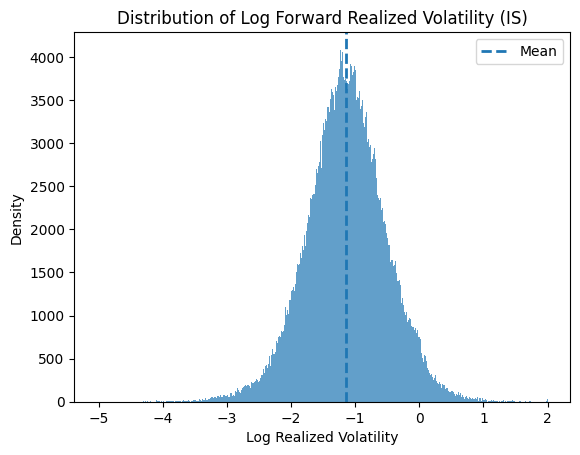

In [10]:
rv = target_df.loc[: "2024-06-30", "target_rv_fwd60m"]

rv = rv[rv > 0]

log_rv = np.log(rv)
mu = log_rv.mean()

plt.hist(log_rv, bins=1000, alpha=0.7)
plt.axvline(mu, linestyle="--", linewidth=2, label="Mean")

plt.title("Distribution of Log Forward Realized Volatility (IS)")
plt.xlabel("Log Realized Volatility")
plt.ylabel("Density")
plt.legend()
plt.show()

### 5. Combine Features & Target

In [11]:
df = pd.concat([features_df, target_df], axis=1)
df = df.dropna(axis=0)

# Add data quality columns from level1_data
df["is_carryover"] = level1_data["is_carryover"]
df["sample_weight"] = level1_data["sample_weight"]

df.head()

,log_ret_1m,log_ret_5m,log_ret_15m,log_ret_30m,log_ret_60m,log_ret_120m,abs_ret_1m,abs_ret_5m,abs_ret_15m,abs_ret_30m,...,day_of_week,sin_dow,cos_dow,is_weekend,is_dst,is_hour_start,is_hour_end,target_rv_fwd60m,is_carryover,sample_weight
ts_end,,,,,,,,,,,,,,,,,,,,,
2023-01-01 02:01:00,-0.000502,-0.000212,0.000333,0.000738,0.001089,0.000254,0.000502,0.000212,0.000333,0.000738,...,6,-0.781831,0.62349,1,0,1,0,0.112397,0,1.0
2023-01-01 02:02:00,0.000169,-0.000296,0.000363,0.000968,0.001046,0.000605,0.000169,0.000296,0.000363,0.000968,...,6,-0.781831,0.62349,1,0,1,0,0.111795,0,1.0
2023-01-01 02:03:00,-0.000054,-0.000514,0.000248,0.000913,0.000701,0.000768,0.000054,0.000514,0.000248,0.000913,...,6,-0.781831,0.62349,1,0,1,0,0.114303,0,1.0
2023-01-01 02:04:00,-0.000175,-0.000622,0.000091,0.000738,0.000550,0.000859,0.000175,0.000622,0.000091,0.000738,...,6,-0.781831,0.62349,1,0,1,0,0.113171,0,1.0
2023-01-01 02:05:00,0.000000,-0.000562,-0.000109,0.000774,0.000702,0.000720,0.000000,0.000562,0.000109,0.000774,...,6,-0.781831,0.62349,1,0,0,0,0.113172,0,1.0


In [12]:
cols = [
    "log_ret_1m",            # return-based
    "rv_60m",                # recent realized vol (state)
    "tick_vol_ema_15m",      # quote-level volatility
    "spread_mean_norm",      # liquidity / cost
    "obi_10bps",             # order book imbalance
    "trade_count_ema_15m",   # activity / flow
    "hour",                  # seasonality
    "target_rv_fwd60m",      # target
]

df[cols].head()

,log_ret_1m,rv_60m,tick_vol_ema_15m,spread_mean_norm,obi_10bps,trade_count_ema_15m,hour,target_rv_fwd60m
ts_end,,,,,,,,
2023-01-01 02:01:00,-0.000502,0.103296,0.065416,0.000007,-0.069092,421.654761,2,0.112397
2023-01-01 02:02:00,0.000169,0.102660,0.062357,0.000006,-0.074855,432.618011,2,0.111795
2023-01-01 02:03:00,-0.000054,0.099518,0.056461,0.000007,-0.168765,426.202096,2,0.114303
2023-01-01 02:04:00,-0.000175,0.100997,0.057897,0.000006,-0.019317,418.811993,2,0.113171
2023-01-01 02:05:00,0.000000,0.099843,0.050660,0.000006,-0.008393,404.694315,2,0.113172


### 6. Walk-Forward CV

In [13]:
folds = [
    ("2023-01-01", "2023-09-30", "2023-10-01", "2023-12-31"), # fold 1
    ("2023-04-01", "2023-12-31", "2024-01-01", "2024-03-31"), # fold 2
    ("2023-07-01", "2024-03-31", "2024-04-01", "2024-06-30"), # fold 3
]

target = target_df.columns[0]

In [14]:
num_leaves_list = [31, 63, 127]
learning_rates  = [0.05, 0.10]

param_grid = [
    {"num_leaves": nl, "learning_rate": lr, "n_estimators": 300}
    for nl in num_leaves_list
    for lr in learning_rates
]

In [15]:
def train_lgb(train_df, val_df, feats, target, params, use_sample_weight=True):
    model = lgb.LGBMRegressor(
        num_leaves=params["num_leaves"],
        learning_rate=params["learning_rate"],
        n_estimators=params["n_estimators"],
        subsample=0.9,
        colsample_bytree=0.9,
        verbose=-1,
        random_state=42
    )
    if use_sample_weight and "sample_weight" in train_df.columns:
        sample_weights = train_df["sample_weight"].values
        model.fit(train_df[feats], train_df[target], sample_weight=sample_weights)
    else:
        model.fit(train_df[feats], train_df[target])
    pred = model.predict(val_df[feats])

    rmse = mean_squared_error(val_df[target], pred) ** 0.5
    mae  = mean_absolute_error(val_df[target], pred)
    ic   = stats.spearmanr(pred, val_df[target]).correlation

    return rmse, mae, ic

In [16]:
tr_start, tr_end, va_start, va_end = folds[0]
test_params = param_grid[0]  # Use first hyperparameter set

train_df = df[(df.index >= tr_start) & (df.index <= tr_end)]
val_df   = df[(df.index >= va_start) & (df.index <= va_end)]

print(f"\nFold 1: Train {tr_start}→{tr_end}, Val {va_start}→{va_end}")
print(f"Train set: {len(train_df)} rows")
print(f"  - Original data (weight=1.0): {(~train_df['is_carryover']).sum()}")
print(f"  - Carryover data (weight=0.5): {train_df['is_carryover'].sum()}")

# Feature selection
feats_ic, ic_series = fs.select_ic(train_df, target)
feats, _, _ = fs.prune_corr(train_df, feats_ic, ic_series)

# Train WITHOUT sample weighting (original method)
print("METHOD 1: WITHOUT Sample Weighting (Original)")
rmse_no_weight, mae_no_weight, ic_no_weight = train_lgb(
    train_df, val_df, feats, target, test_params, use_sample_weight=False
)
print(f"Results: RMSE={rmse_no_weight:.6f}, MAE={mae_no_weight:.6f}, IC={ic_no_weight:.6f}")

print("METHOD 2: WITH Sample Weighting (Improved)")
rmse_with_weight, mae_with_weight, ic_with_weight = train_lgb(
    train_df, val_df, feats, target, test_params, use_sample_weight=True
)
print(f"Results: RMSE={rmse_with_weight:.6f}, MAE={mae_with_weight:.6f}, IC={ic_with_weight:.6f}")

# Show differences
print("\n" + "=" * 80)
print("IMPACT OF SAMPLE WEIGHTING")
print("=" * 80)
rmse_diff = rmse_with_weight - rmse_no_weight
mae_diff = mae_with_weight - mae_no_weight
ic_diff = ic_with_weight - ic_no_weight

print(f"RMSE change: {rmse_diff:+.6f} ({100*rmse_diff/rmse_no_weight:+.2f}%)")
print(f"MAE change:  {mae_diff:+.6f} ({100*mae_diff/mae_no_weight:+.2f}%)")
print(f"IC change:   {ic_diff:+.6f} ({100*ic_diff/ic_no_weight:+.2f}%)")


Fold 1: Train 2023-01-01→2023-09-30, Val 2023-10-01→2023-12-31
Train set: 389231 rows
  - Original data (weight=1.0): -389295
  - Carryover data (weight=0.5): 64
METHOD 1: WITHOUT Sample Weighting (Original)
Results: RMSE=0.233985, MAE=0.103241, IC=0.783219
METHOD 2: WITH Sample Weighting (Improved)
Results: RMSE=0.233415, MAE=0.103132, IC=0.782946

IMPACT OF SAMPLE WEIGHTING
RMSE change: -0.000570 (-0.24%)
MAE change:  -0.000109 (-0.11%)
IC change:   -0.000272 (-0.03%)


In [17]:
tuning_results = []

for p_i, params in enumerate(param_grid, 1):
    print(f"\nHyperparameter set {p_i}/{len(param_grid)}: {params}")
    fold_scores = []

    for f_i, (tr_start, tr_end, va_start, va_end) in enumerate(folds, 1):
        print(f"\nFold {f_i}")
        print(f"  Training window:   {tr_start} to {tr_end}")
        print(f"  Validation window: {va_start} to {va_end}")

        train_df = df[(df.index >= tr_start) & (df.index <= tr_end)]
        val_df   = df[(df.index >= va_start) & (df.index <= va_end)]

        print("  Selecting features (IC ranking)...")
        feats_ic, ic_series = fs.select_ic(train_df, target)

        print("  Pruning correlated features...")
        feats, _, _ = fs.prune_corr(train_df, feats_ic, ic_series)

        print(f"  Features used: {len(feats)}")

        print("  Training model...")
        rmse, mae, ic = train_lgb(train_df, val_df, feats, target, params, use_sample_weight=True)

        print(f"  Fold {f_i} RMSE={rmse:.4f}, MAE={mae:.4f}, IC={ic:.4f}")

        fold_scores.append({"rmse": rmse, "mae": mae, "ic": ic})

    avg_rmse = np.mean([s["rmse"] for s in fold_scores])
    avg_mae  = np.mean([s["mae"]  for s in fold_scores])
    avg_ic   = np.mean([s["ic"]   for s in fold_scores])

    tuning_results.append({
        "params": params,
        "avg_rmse": avg_rmse,
        "avg_mae": avg_mae,
        "avg_ic": avg_ic
    })

    print(f"\nFinished hyperparameter set {p_i}")
    print(f"  Average RMSE={avg_rmse:.4f}, MAE={avg_mae:.4f}, IC={avg_ic:.4f}")


Hyperparameter set 1/6: {'num_leaves': 31, 'learning_rate': 0.05, 'n_estimators': 300}

Fold 1
  Training window:   2023-01-01 to 2023-09-30
  Validation window: 2023-10-01 to 2023-12-31
  Selecting features (IC ranking)...
  Pruning correlated features...
  Features used: 14
  Training model...
  Fold 1 RMSE=0.2334, MAE=0.1031, IC=0.7829

Fold 2
  Training window:   2023-04-01 to 2023-12-31
  Validation window: 2024-01-01 to 2024-03-31
  Selecting features (IC ranking)...
  Pruning correlated features...
  Features used: 19
  Training model...
  Fold 2 RMSE=0.2695, MAE=0.1370, IC=0.8071

Fold 3
  Training window:   2023-07-01 to 2024-03-31
  Validation window: 2024-04-01 to 2024-06-30
  Selecting features (IC ranking)...
  Pruning correlated features...
  Features used: 19
  Training model...
  Fold 3 RMSE=0.2143, MAE=0.1512, IC=0.7859

Finished hyperparameter set 1
  Average RMSE=0.2391, MAE=0.1304, IC=0.7920

Hyperparameter set 2/6: {'num_leaves': 31, 'learning_rate': 0.1, 'n_estim

In [18]:
tuning_results_sorted = sorted(tuning_results, key=lambda x: -x["avg_ic"])
best_params = tuning_results_sorted[0]["params"]

print("\nBest hyperparameters based on IC:")
print(best_params)


Best hyperparameters based on IC:
{'num_leaves': 31, 'learning_rate': 0.05, 'n_estimators': 300}


### 8. Train Final Model

In [19]:
pretest_df = df[: "2024-06-30"]
test_df    = df["2024-07-01":]

# Feature selection on ALL pre-test data
feats_ic, ic_series = fs.select_ic(pretest_df, target)

feats, corr_mat, dropped = fs.prune_corr(pretest_df, feats_ic, ic_series)
print(f"  Features used: {len(feats)}")

# Final model training (with sample weighting for carryover data quality)
final_model = lgb.LGBMRegressor(
    num_leaves=best_params["num_leaves"],
    learning_rate=best_params["learning_rate"],
    n_estimators=best_params["n_estimators"],
    subsample=0.9,
    colsample_bytree=0.9,
    verbose=-1,
    random_state=42
)

# Use sample weights: carryover data gets 0.5 weight, original data gets 1.0
sample_weights = pretest_df["sample_weight"].values
final_model.fit(pretest_df[feats], pretest_df[target], sample_weight=sample_weights)
oos_pred = final_model.predict(test_df[feats])

rmse = mean_squared_error(test_df[target], oos_pred)**0.5
mae  = mean_absolute_error(test_df[target], oos_pred)
ic   = stats.spearmanr(oos_pred, test_df[target]).correlation

r2 = r2_score(test_df[target], oos_pred)

# --- NEW: ICIR (rolling daily IC) ---
ic_df = pd.DataFrame({
    "pred": oos_pred,
    "target": test_df[target]
}, index=test_df.index)

# daily IC
daily_ic = (
    ic_df
    .groupby(ic_df.index.date)
    .apply(lambda x: stats.spearmanr(x["pred"], x["target"]).correlation)
)

icir = daily_ic.mean() / daily_ic.std()

print("\nFinal OOS Performance")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"R^2  : {r2:.4f}")
print(f"IC   : {ic:.4f}")
print(f"ICIR : {icir:.4f}")

  Features used: 21

Final OOS Performance
RMSE : 0.1995
MAE  : 0.1145
R^2  : 0.5137
IC   : 0.8034
ICIR : 3.9127


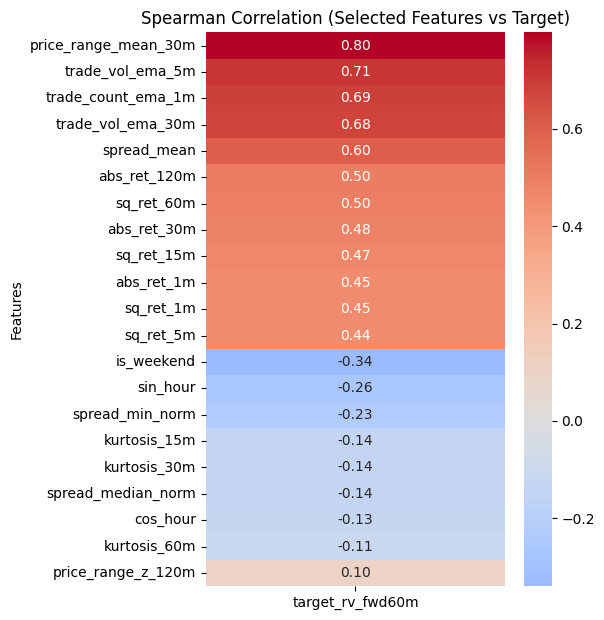

In [20]:
# Compute Spearman correlation (feature vs target)
spearman_corr = pretest_df[feats + [target]].corr(method="spearman")[target].drop(target)

plt.figure(figsize=(6, max(6, len(feats)*0.3)))
sns.heatmap(
    spearman_corr.to_frame(),
    annot=True,
    cmap="coolwarm",
    center=0,
    fmt=".2f",
    cbar=True
)
plt.title("Spearman Correlation (Selected Features vs Target)")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

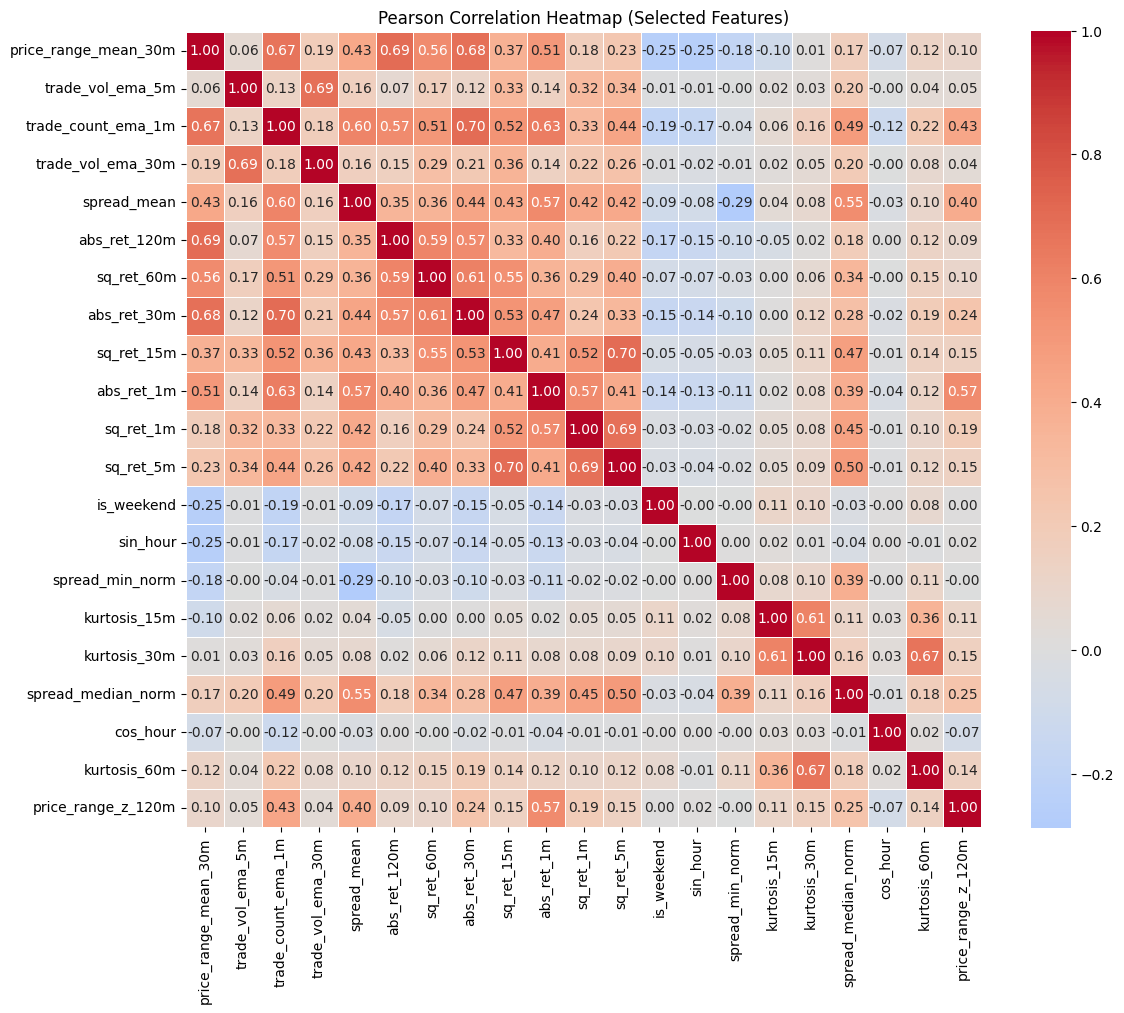

In [21]:
pearson_corr = pretest_df[feats].corr(method="pearson")

plt.figure(figsize=(12, 10))
sns.heatmap(
    pearson_corr,
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".2f",
    square=True,
    linewidths=0.5
)
plt.title("Pearson Correlation Heatmap (Selected Features)")
plt.tight_layout()
plt.show()

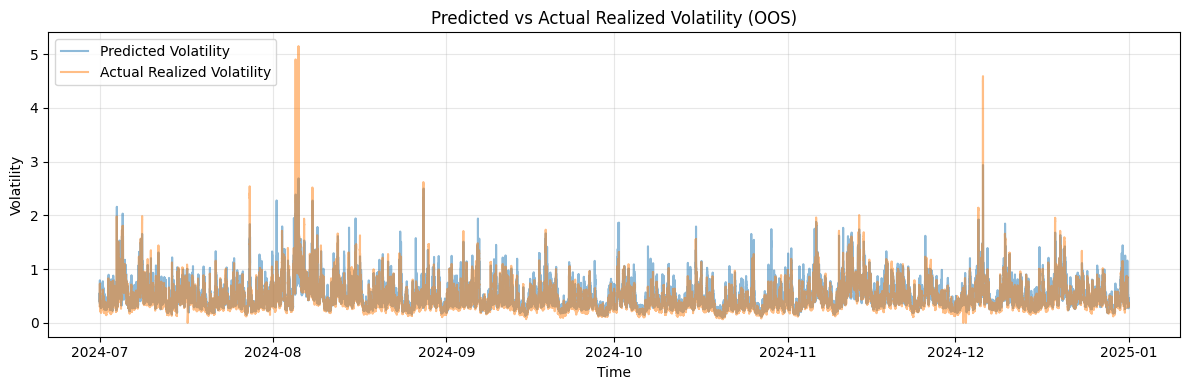

In [22]:
import matplotlib.dates as mdates
plt.figure(figsize=(12,4))
plt.plot(test_df.index, oos_pred, label='Predicted Volatility', alpha=0.5)
plt.plot(test_df.index, test_df[target], label='Actual Realized Volatility', alpha=0.5)
plt.title('Predicted vs Actual Realized Volatility (OOS)')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.show()

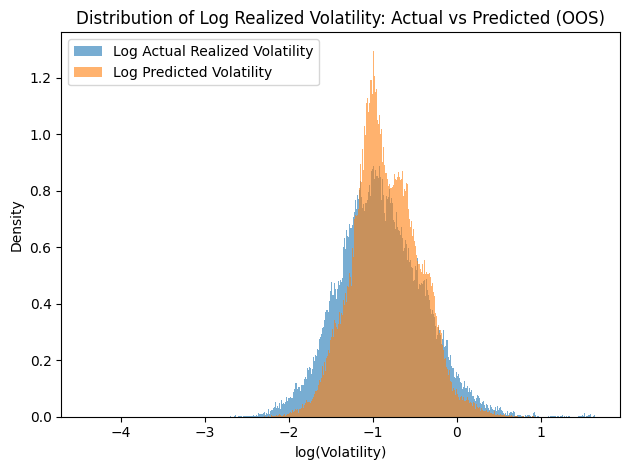

In [23]:
mask = test_df[target] > 0

actual = np.log(test_df.loc[mask, target])
pred   = np.log(oos_pred[mask])

# plt.figure(figsize=(8, 5))
plt.hist(actual, bins=1000, alpha=0.6, label="Log Actual Realized Volatility", density=True)
plt.hist(pred,   bins=1000, alpha=0.6, label="Log Predicted Volatility", density=True)

plt.title("Distribution of Log Realized Volatility: Actual vs Predicted (OOS)")
plt.xlabel("log(Volatility)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


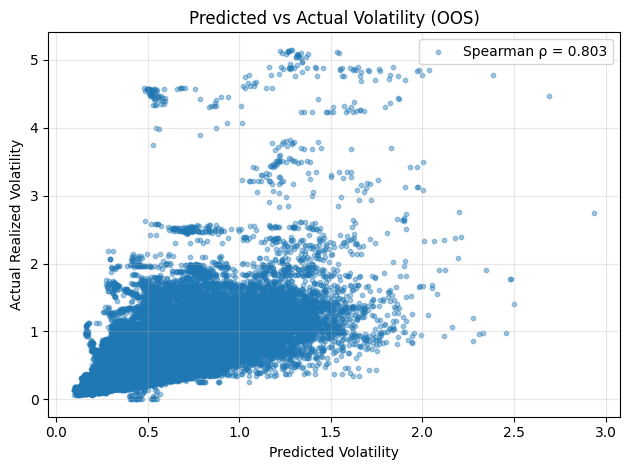

In [24]:
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

rho, _ = spearmanr(oos_pred, test_df[target])

# Scatter plot: Predicted vs Actual Volatility
plt.scatter(
    oos_pred,
    test_df[target],
    alpha=0.4,
    s=10,
    label=f"Spearman ρ = {rho:.3f}"
)
plt.xlabel('Predicted Volatility')
plt.ylabel('Actual Realized Volatility')
plt.title('Predicted vs Actual Volatility (OOS)')
plt.legend()

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Series
pred = pd.Series(oos_pred, index=test_df.index)
actual = test_df[target]

# 7-day rolling window (minute data)
window = 7 * 24 * 60

rolling_ic = [
    spearmanr(
        pred.iloc[i:i+window],
        actual.iloc[i:i+window]
    ).correlation
    for i in range(len(pred) - window)
]

rolling_ic = pd.Series(
    rolling_ic,
    index=test_df.index[window:]
)

# Plot
plt.figure(figsize=(12, 4))
plt.plot(rolling_ic, linewidth=2, label="Rolling IC")
# plt.axhline(0, linestyle="-", alpha=0.5)
plt.axhline(rolling_ic.mean(), linestyle="--", label=f"Mean IC = {rolling_ic.mean():.3f}")

plt.title("Rolling 7-Day Spearman IC (OOS)")
plt.ylabel("Spearman IC")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
lgb.plot_importance(final_model)
plt.show()

### Backtest

Median of pre-test realized vol: 0.3191



Category,Buy & Hold,Vol-Managed
Metric_Name,,
Annualized Sharpe,1.6310,1.7671
Annualized Sortino,2.1726,2.5766
Annualized Volatility,0.5402,0.3439
Cumulative Return,0.4425,0.3051
Max DD,-0.2955,-0.1697


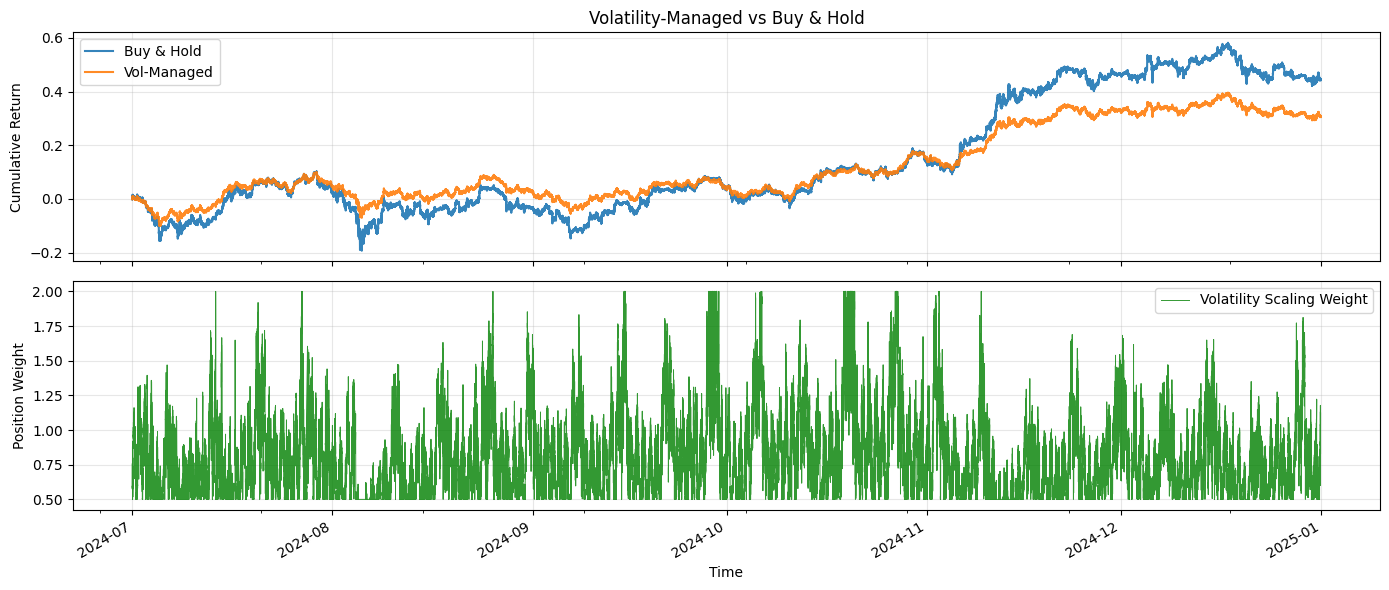

In [ ]:
pretest_rv = df.loc["2023-01-01":"2024-06-30", "target_rv_fwd60m"]

sigma_target = np.median(pretest_rv)
print(f"Median of pre-test realized vol: {sigma_target:.4f}\n")

oos_pred = pd.Series(oos_pred, index=test_df.index)

actual_returns = df["log_ret_1m"].loc[test_df.index].shift(-1)   # your actual next-period returns

strat_ret, base_ret, metrics, w = bt.vol_managed_backtest(
    returns=actual_returns,
    pred_vol=oos_pred,
    sigma_target=sigma_target
)

table = bt.metrics_to_table(metrics)
display(table.round(4))
bt.plot_backtest(strat_ret, base_ret, w)